# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# Chapitre 2 - Introduction à la régression linéaire

Ce calepin Jupyter accompage le chapitre 2 des notes de cours.

Chargeons d'abord les librairies nécessaires.

In [1]:
using CSV, DataFrames             # Pour charger et organiser les données
using Gadfly                      # Pour générer des graphiques
using Distributions               # Pour utiliser les distributions statistiques
using LinearAlgebra               # Pour utiliser les fonctions d'algèbre linéaire
using Random

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/jalbert/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


In [2]:
include("functions.jl")

splitdataframe

# Chargement des données

In [3]:
# Chargement du fichier de données 
data = CSV.read("FF_emissions.csv");

# Les colonnes sont renommées avec des noms plus courts
rename!(data, :FF_emissions => :FF)
rename!(data, :LUC_emissions => :LUC)
rename!(data, :ocean_sink => :Ocean)
rename!(data, :land_sink => :Land)
rename!(data, :T_anomaly => :T)

# Les oceans et les strates végétales absorbent le carbone
data[!,:Ocean] = -data[!,:Ocean]
data[!,:Land] = -data[!,:Land]

# Affichage des 5 premières lignes du tableau de données
first(data,5)

,Year,FF,LUC,Ocean,Land,T
,Int64,Float64,Float64,Float64,Float64,Float64
1,1959,2.45,1.47,-0.92,-0.97,0.08
2,1960,2.57,1.46,-0.93,-1.59,0.08
3,1961,2.58,1.53,-0.8,-1.65,0.15
4,1962,2.69,1.52,-0.87,-2.15,0.06
5,1963,2.83,1.53,-1.03,-2.12,0.05


In [4]:
# On retire les données de la structure DataFrames pour faire les calculs sans utiliser les packages de la régression
X₁ = convert(Array{Float64},data[!,:FF])
X₂ = convert(Array{Float64},data[!,:LUC])
X₃ = convert(Array{Float64},data[!,:Ocean])
X₄ = convert(Array{Float64},data[!,:Land])
Y = convert(Array{Float64},data[!,:T])
n = length(Y);

# Analyse exploratoire

Étape permettant d'obtenir une vision globale du jeu de données. Elle peut également permettre de découvrir des dépendances entre les variables. L'analyse exploratoire peut s'affectuer à l'aide de graphiques et de statistiques simples.

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping(::DataFrame, ::Symbol) at dataframes.jl:96
└ @ Gadfly /Users/jalbert/.julia/packages/Gadfly/09PWZ/src/dataframes.jl:96


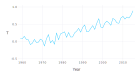

In [5]:
# Traçage de l'anomalie de température en fonction des années
Gadfly.set_default_plot_size(14cm, 8cm)
fig1 = plot(data, x=:Year, y=:T, Geom.line,
    Coord.Cartesian(xmin=1959, xmax=2015), Guide.xticks(ticks=collect(1960:10:2015))) 


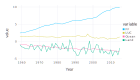

In [6]:
# Traçage des composantes du cycle du carbone en fonction des années
Gadfly.set_default_plot_size(14cm, 8cm)
fig2 = plot(stack(data, [:FF, :LUC, :Ocean, :Land]), x=:Year, y=:value, color=:variable, Geom.line,
    Coord.Cartesian(xmin=1959, xmax=2015), Guide.xticks(ticks=collect(1960:10:2015)) )


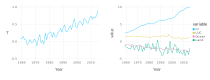

In [7]:
Gadfly.set_default_plot_size(21cm, 8cm)
hstack(fig1, fig2)

# Préliminaires

Pour justifier l'intétrêt de la régression linéaire, tentons de faire passer une courbe par tous les points d'un échantillon d'entraînement.

### Anomalies de températures en fonction de la quantité de carbone émise par les combustibles fossiles

Traçage du nuage de points.

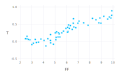

In [8]:
Gadfly.set_default_plot_size(12cm, 8cm)
plot(data, x=:FF, y=:T, Geom.point, Coord.cartesian(xmin=2), Guide.xticks(ticks=collect(2:10)))

### Partionnement du jeu de données

Partionnement du jeu de données en un ensemble d'entraînement et de validation avec la fonction `splitdataframe`.

In [9]:
train, valid = splitdataframe(data,.2)
train

,Year,FF,LUC,Ocean,Land,T
,Int64,Float64,Float64,Float64,Float64,Float64
1,1960,2.57,1.46,-0.93,-1.59,0.08
2,1961,2.58,1.53,-0.8,-1.65,0.15
3,1970,4.05,1.53,-1.21,-1.98,0.03
4,1976,4.86,1.32,-1.65,-2.48,-0.08
5,1988,5.94,1.51,-1.87,-0.81,0.38
6,1991,6.17,1.64,-2.13,-4.12,0.48
7,1993,6.12,1.55,-2.42,-2.67,0.29
8,2003,7.47,0.9,-2.38,-1.16,0.54
9,2008,8.96,0.67,-2.47,-3.38,0.53


### Estimation de la courbe passant par tous les points

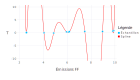

In [10]:
y = train[:,:T]
x = train[:,:FF]
n = length(y)

# Matrice de structure des n équations pour les n inconnus
X = Array{Float64}(undef,n,n)
X[:,1] .= 1 

for i=1:n
    for j=2:n
        X[i,j] = x[i]^(j-1)
    end
end

# Résolution du système linéaire
β = X\y


# Création d'un vecteur pour afficher une courbe
xx = collect(2:.01:10)

X̃ = Array{Float64}(undef,length(xx),n)
X̃[:,1] .= 1 

for i=1:length(xx)
    for j=2:n
        X̃[i,j] = xx[i]^(j-1)
    end
end

yy = X̃*β


# Traçage du nuages de points et de la courbe
sample = layer( x=x, y=y, Geom.point, Theme(default_color="deepskyblue"))
curve = layer(x=xx, y = yy, Geom.line, Theme(default_color="red"))

# Traçage du graphique
Gadfly.set_default_plot_size(14cm, 8cm)
plot(sample,curve ,
    Guide.manual_color_key("Légende", ["Échantillon", "Spline"], ["deepskyblue","red"]),
    Coord.Cartesian(xmin=2,xmax=10,ymin=-10,ymax=10), Guide.xlabel("Émissions FF"), Guide.ylabel("T"))

#=
On peut remarquer que ce modèle est très instable. De plus, la performance de ce modèle est nulle sur 
l'échantillon de validation. On est dans un cas de «sur-aprentissage».
=#


# 2.1 Modèle de régression linéaire simple

Pour commencer, on utilise seulement les émissions par combustion de combustibles fossibles 
comme variable explicative.

### Estimation des paramètres du modèle de régression linéaire simple

In [11]:
# taille de l'échantillon
n = length(Y)

# Calcul des statistiques utiles
x̄ = mean(X₁)
ȳ = mean(Y)

# Estimation des paramètres
β̂₁ = sum( (X₁[i] - x̄)*(Y[i] - ȳ) for i=1:n) / sum( (X₁[i] - x̄)^2 for i=1:n )

β̂₀ = ȳ - β̂₁*x̄

println("L'ordonnée à l'origine estimée est β̂₀=$(β̂₀)")
println("La pente de la droite de régression estimée est β̂₁=$(β̂₁)")


L'ordonnée à l'origine estimée est β̂₀=-0.3574329447398635
La pente de la droite de régression estimée est β̂₁=0.11316846326977269


### Affichage de la droite de régression

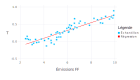

In [12]:
# couche du graphique pour les observations
sample = layer( x=X₁, y=Y, Geom.point, Theme(default_color="deepskyblue"))

# couche du graphique pour la droite de régression
xx = collect(range(minimum(X₁),stop=maximum(X₁),length=10))
regression = layer(x=xx, y = β̂₀ .+ β̂₁*xx, Geom.line, Theme(default_color="red"))

# Traçage du graphique
Gadfly.set_default_plot_size(14cm, 8cm)
plot(sample,regression ,
    Guide.manual_color_key("Légende", ["Échantillon", "Régression"], ["deepskyblue","red"]),
    Coord.Cartesian(xmin=2,xmax=10), Guide.xlabel("Émissions FF"), Guide.ylabel("T"))


# 2.2 Modèle de régression linéaire multiple

Dans cette section, toutes les variables explicatives sont utilisées pour expliquer les anomalies de température.

### 2.2.1 Estimation des paramètres du modèle de régression multiple

Estimation des paramètres à l'aide de la méthode des moindres carrés.

In [13]:
# taille de l'échantillon
n = length(Y)

# Construction de la matrice de structure
X = hcat(ones(n),X₁,X₂,X₃,X₄)

# Estimation des paramètres du modèle de régression
β̂ = (X'X)\X'Y

println("Les estimations des coefficient de régression sont β̂ = $(β̂)")

Les estimations des coefficient de régression sont β̂ = [-0.5973852647803128, 0.171106940899803, 0.18789865318566154, 0.13484499901704466, 0.04406430037649416]


### 2.2.2 Estimation de la variance de l'erreur

In [14]:
# Nb de variables explicatives
p = size(X,2)-1 # la colonne de 1 ne constitue pas une variable explicative

# Calcul des résidus (erreurs observés)
e = Y-X*β̂

# Estimation de la variance de l'erreur
σ̂² = 1/(n-p-1)*sum( e.^2 )

println("σ̂² = $σ̂²")

σ̂² = 0.009939913109308664


### 2.2.3 Prévision de l'anomalie de température

Supposons que l'on veut savoir qu'elle sera l'anomalie de température si on émet les quantités suivantes :

 - 10 Gt de C par FF
 - 1.5 Gt de C par LUC
 - -1 Gt de C par Ocean
 - -1 Gt de C par Land

In [15]:
# Définition du vecteur des variables explicatives pour lesquelles on veut estimer la variable d'intérêt
x₀ = [1 10 1.5 -1 -1]

# Estimation de l'anomalie de température
Ŷ₀ = x₀*β̂

println("L'anomalie de température estimée correspondante est de $(Ŷ₀)")

L'anomalie de température estimée correspondante est de [1.2166228246026705]


# 2.3 Validation des hypothèses de la régression linéaire

Analyse visuelle des résidus

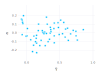

In [16]:
# Affichage des résidus

# Calcul des estimations
Ŷ = X*β̂

# Calcul des résidus (erreurs observées)
e = Y .- Ŷ

# Stockage des variables dans un DataFrame pour un affichage plus facile
df = DataFrame(Ŷ = Ŷ, e = e)

Gadfly.set_default_plot_size(10cm, 8cm)
plot(df, x = :Ŷ, y = :e, Geom.point, Coord.Cartesian(xmin=-.1,xmax=1,ymin=-.3,ymax=.3))


# 2.6 Tests d'hypothèses et intervalles de confiance

Avant tout, vérifions si l'hypothèse de normalité des résidus est raisonnable.

In [17]:
function henryplot(y::Array{<:Real,1})
   
    n = length(y)
    ysorted = sort(y)
    
    p = ( collect(1:n) .- .5 ) /n
    
    fd = fit(Normal,y)
    
    q = quantile.(fd,p)
    
    plot(x=ysorted, y=q, Geom.point, Geom.abline(color="red"))
    
end

henryplot (generic function with 1 method)

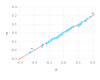

In [18]:
henryplot(e)

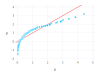

In [19]:
x = rand(Gamma(),100)
henryplot(x)

### 2.6.1 Test sur l’importance de la régression

In [20]:
ȳ = mean(Y)

SST = sum( (Y .- ȳ).^2 )
SSR = sum( (Ŷ .- ȳ).^2 )
SSE = sum(e.^2)

R² = SSR/SST

println("Le coefficient de détermination de la régression est R² = $R²")

Le coefficient de détermination de la régression est R² = 0.8656284521999534


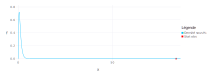

In [21]:
# Calcul de la statistique observée du test
F₀ = SSR/SSE * (n-p-1)/p

xx = 0:.1:100
pd = FDist(p, n-p-1) 
f = pdf.(pd,xx)

density= layer(x=xx, y=f, Geom.line, Theme(default_color="deepskyblue"))
statObs = layer(x=[F₀], y=[0], Geom.point, Theme(default_color="red") )

Gadfly.set_default_plot_size(21cm, 8cm)
plot(density, statObs,
    Guide.manual_color_key("Légende", ["Densité sous H₀", "Stat obs"], ["deepskyblue","red"]),
    Coord.Cartesian(xmin=0,xmax=85), Guide.xlabel("x"), Guide.ylabel("f"))

In [22]:
# Première façon de tester l'importance de la régression : comparaison avec le seuil critique

α = 0.05
point_critique = cdf(pd,1-α)
if F₀ > point_critique
    println("La régression est significative au seuil de $α car F₀ > point critique.
        On a en effet que F₀ = $F₀ > $point_critique)")
else
    println("La régression n'est pas significative au seuil de $α car F₀ < point critique.
        On a en effet que F₀ = $F₀ < $point_critique)")
end

La régression est significative au seuil de 0.05 car F₀ > point critique.
        On a en effet que F₀ = 83.74667154497865 > 0.557235234867715)


In [23]:
# Deuxième façon de tester l'importance de la régression : calcul de la valeur-p

α = 0.05
# calcul de la probabilité d'observer une statistique plus extrême que celle obtenue
seuil_observe = ccdf(pd,F₀) # la fonction ccdf correspond à 1-cdf()
if seuil_observe < α
    println("La régression est significative au seuil de $α car le seuil observé du test est plus petit que α.
        On a en effet que seuil observé = $seuil_observe < $α")
else
    println("La régression n'est pas significative au seuil de $α car le seuil observé du test est plus grand que α.
        On a en effet que seuil observé = $seuil_observe > $α")
end

La régression est significative au seuil de 0.05 car le seuil observé du test est plus petit que α.
        On a en effet que seuil observé = 5.095365269186253e-22 < 0.05


### 2.6.2 Intervalles de confiance sur les coefficients de régression

In [24]:
# calcul du quantile de la loi de Student
tₐ = cdf(TDist(n-p-1),.975)

# Calcul de l'inverse de la matrice de X'X
C = inv(X'X)

# Affichage des intervalles de confiance
coeff_names = ["β₀", "β₁", "β₂", "β₃", "β₄"]
for j=0:p
    se = tₐ*sqrt(σ̂²*C[j+1,j+1])
   println("L'intervalle de confiance de $(coeff_names[j+1]) est [$(β̂[j+1] - se) , $(β̂[j+1] + se)")
end

L'intervalle de confiance de β₀ est [-0.7020794944872863 , -0.4926910350733394
L'intervalle de confiance de β₁ est [0.1489603997431932 , 0.1932534820564128
L'intervalle de confiance de β₂ est [0.12572799840005294 , 0.25006930797127014
L'intervalle de confiance de β₃ est [0.061209921995892716 , 0.20848007603819663
L'intervalle de confiance de β₄ est [0.03235730652803677 , 0.055771294224951556


### 2.6.3 Intervalle de confiance sur une prévision

Reprenons la prévision de la section 2.2.3. Calculons maintenons un intervalle de confiance de niveau 95 % pour cette prévision.


In [25]:
# Vecteur des variables explicatives
x₀ = [1 10 1.5 -1 -1]

# Prévision
Ŷ₀ = x₀*β̂

# Calcul de la marge d'erreur
se = cdf(TDist(n-p-1),.975)*sqrt( 1 .+ σ̂² * x₀/(X'X)*x₀' )


println("L'intervalle de confiance de Ŷ₀ est [$(Ŷ₀[1] - se[1]) , $(Ŷ₀[1] + se[1])]")

L'intervalle de confiance de Ŷ₀ est [0.36709597233550506 , 2.066149676869836]


# 2.7 Comparaison des modèles

### 2.7.1 Coefficient de détermination ajusté pour le modèle complet

In [26]:
p = size(X,2)-1 # nombre de variables explicatives

R² =  1 - SSE/SST * (n-1)/(n-p)

println("Le coefficient de détermination ajusté est de $(R²)")


Le coefficient de détermination ajusté est de 0.8580225155320452


### 2.7.2 Coefficient de détermination des prévisions

In [27]:
# Calcul de la matrice H pour la validation croisée
H = X/(X'*X)*X'

# Calcul des erreurs de validation croisée
ẽ = e./(1 .- diag(H))

# Calcul du coefficient de détermination de prévision
R̃² = 1-sum(ẽ.^2)/ SST

println("Le coefficient de détermination de prévision est de $(R̃²)")

Le coefficient de détermination de prévision est de 0.8400233330047855


### Calcul des mesures de qualité pour tous les modèles possibles

In [28]:

# Création d'un dataframe pour conserver les R² de tous les modèles
df = DataFrame(FF = Int64[], LUC = Int64[], Ocean = Int64[], Land=Int64[], R2aj = Float64[], R2prev = Float64[])

for i=0:1
    for j=0:1
        for k=0:1
            for l=0:1
            
                # Construction de la matrice des variables explicatives
                X = ones(n,1)
                if i==1
                    X = hcat(X,X₁)
                end
                if j==1
                   X = hcat(X,X₂)
                end
                if k==1
                    X = hcat(X,X₃)
                end
                if l==1
                    X = hcat(X,X₄)
                end

                # estimation des paramètres
                β̂ = (X'*X)\X'*Y
                # Calculs des résidus
                e = Y .- X*β̂
                # Calcul de la matrice H pour la validation croisée
                H = X/(X'*X)*X'
                # Calcul des erreurs de validation croisée
                ẽ = e./(1 .- diag(H))
                # Calcul du coefficient de détermination de prévision
                R̃² = 1-sum(ẽ.^2)/ SST

                # Calcul du coefficient de détermination ajusté
                p = size(X,2)-1
                SSE = sum(e.^2)
                R² =  1 - SSE/SST * (n-1)/(n-p)

                # Stocker les résultats dans le dataframe
                push!(df,[i j k l R² R̃²])
                
            end
        end
    end
end

sort(df,:R2aj,rev=true)


,FF,LUC,Ocean,Land,R2aj,R2prev
,Int64,Int64,Int64,Int64,Float64,Float64
1,1,1,1,1,0.858023,0.840023
2,1,1,0,1,0.854417,0.838016
3,1,0,0,1,0.846293,0.830411
4,1,0,1,1,0.843668,0.824043
5,1,1,0,0,0.834963,0.821094
6,1,1,1,0,0.834311,0.81788
7,1,0,0,0,0.828575,0.816233
8,1,0,1,0,0.825495,0.808563
9,0,1,1,0,0.750086,0.714065


# 2.8  Identification des données suspectes

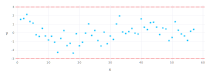

In [29]:
# taille de l'échantillon
n = length(Y)

# Construction de la matrice de structure (on conserve le meilleur modèle obtenu à la section précédente)
X = hcat(ones(n),X₁,X₂,X₃,X₄)

# Estimation des paramètres du modèle de régression
β̂ = (X'X)\X'Y

# Calcul des résidus
e = Y .- X*β̂

# Estimation de l'erreur
σ̂² = 1/(n-p-1)*sum( e.^2 )

# Calcul de la matrice H
H = X/(X'X)*X'

s = [e[i]/sqrt(σ̂²*(1-H[i,i])) for i=1:n]

plot(x=1:n, y=s, Geom.point,
    yintercept=[-3.0, 3.0], Geom.hline(color=["red","red"], style=[:dash,:dash]))

# Toutes les valeurs sont entre -3 et 3. Il n'y a donc aucune valeur suspecte.

# 2.9 Détection de la multicolinéarité

### 2.9.2 Détection de la multicolinéarité avec les valeurs propres

In [30]:
function check_multicol(X::Array{T,2} where T<:Real)
   
    # Standardization of the explanatory variables, except the column of ones
    m = mean(X, dims=1)
    s = std(X, dims=1)
    
    m[1] = 0
    s[1] = 1
    
    X̃ = (X .- m) ./s
    
    
    # compute the singular values
    λ = svdvals(X̃)
    # Calculer les valeurs singulières de X est plus efficace que calculer les valeurs propres de X'X
    
    # Coompute the multicollinearity index
    ϕ = maximum(λ) / minimum(λ)
    
    if ϕ > 30
        multicol = true
    else
        multicol = false
    end
    
    return multicol
end

check_multicol (generic function with 1 method)

In [31]:
multicol = check_multicol(X)

if multicol
    println("Il y a présence de multicolinéarité.")
else
    println("Il n'y a pas de multicolinéarité.")
end

Il n'y a pas de multicolinéarité.


# Les résultats peuvent être reproduits avec la librairie GLM

In [32]:
using GLM

In [33]:
# Construction du modèle linéaire
M = lm(@formula(T ~ FF + LUC + Ocean + Land), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

T ~ 1 + FF + LUC + Ocean + Land

Coefficients:
──────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error   t value  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.597385    0.125689   -4.75289    <1e-4   -0.849599   -0.345172
FF            0.171107    0.0265877   6.43557    <1e-7    0.117755    0.224459
LUC           0.187899    0.074638    2.51747    0.0149   0.0381266   0.337671
Ocean         0.134845    0.0884014   1.52537    0.1332  -0.0425454   0.312235
Land          0.0440643   0.0140546   3.13521    0.0028   0.0158616   0.072267
──────────────────────────────────────────────────────────────────────────────

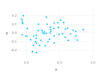

In [34]:
# Extraction des résidus
e = residuals(M)

# Obtention des estimations aux points observés
Ŷ = predict(M,X)

Gadfly.set_default_plot_size(10cm, 8cm)
plot(x=Ŷ, y=e, Geom.point, Coord.Cartesian(xmin=-.1,xmax=1,ymin=-.3,ymax=.3))


In [35]:
# Prévision 
x₀ = [1 10 1.5 -1.0 -1.0]
Ŷ₀ = predict(M,x₀)

1-element Array{Float64,1}:
 1.2166228246027029